# Segmentasi Pelanggan dengan Analisis RFM dan K-Means Clustering

# Business Understanding

Berapa banyak biaya digunakan untuk mendatangkan pelanggan baru, versus biaya untuk mempertahankan pelanggan lama? Mempertahankan pelanggan sama pentingnya dengan mendatangkan pelanggan baru. Jika rate pelanggan pindah lebih besar daripada rate pelanggan baru, berarti jumlah customer base kita turun. 

Memeriksa data transaksi customer satu per satu tidak efisien. Diperlukan teknik tertentu untuk mem-present data ke level agregat.

Analisis RFM digunakan untuk mensegmen customer menjadi kelompok homogen. Ada 3 variabel utama: R-Recency, Frequency, Monetary. F dan M menunjukkan nilai customer, dan R menunjukkan nilai kepuasan customer. Nilai RFM bisa didapatkan dengan mudah dari data transaksi.

Analisis RFM bisa menjawab pertanyaan berikut:
Siapa saja yang termasuk best / most valuable customer?
Siapa saja customer yang perlu dipertahankan?
Siapa saja customer yang Churn? Berapa churn rate-nya?
Siapa saja target customer untuk launching produk baru?

Aplikasi nilai RFM pada umumnya yaitu sebagai berikut. Aplikasi ini bisa berbeda untuk sektor tertentu dan bisa berbeda juga tergantung dari definisi yang diberikan si Analis.
R - Nilai R tinggi menunjukkan customer membeli belakangan ini dan kemungkinan besar akan merespons positif terhadap promosi.
Nilai R rendah menunjukkan kemungkinan Churn.
F - Nilai F tinggi menunjukkan customer mengulang pembelian (demand/loyalitas tinggi).
M - Nilai M tinggi menunjukkan pembelian dalam jumlah besar (customer high value).

Kelebihan Analisis RFM:
Bisa dilakukan dengan sedikit variabel.
Cepat dan mudah diaplikasikan dan dipahami.
Efektif untuk rencana marketing short-term.

Kelemahan Analisis RFM:
Memakai data historis. Penggunaan terbatas pada existing customer base. Kurang efektif untuk analisis prospek.
Result is drawn from historical data, impact is limited to existing customers and is less useful for new customers.

# Data Preprocessing

## Step 1: Checking and preprocessing data

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
import datetime as dt
import numpy as np

In [2]:
print('Loading Data...')
df = pd.read_csv("Retail_Data_Transactions.csv")
df.head()

print('Loading Completed...')

Loading Data...
Loading Completed...


In [3]:
df.isna().sum()

customer_id    0
trans_date     0
tran_amount    0
dtype: int64

In [4]:
sum_nan = 0
for col in list(df.columns):
    if any(df[col].isnull()):
        sum_nan += 1
print('--- Checking for NULL')
print(f'There is {sum_nan} NULL value(s)')

--- Checking for NULL
There is 0 NULL value(s)


In [5]:
print('--- Dimension of Data ---')
print()
print('Number of Records: ', df.shape[0])
print('Number of Features: ', df.shape[1])
print()

--- Dimension of Data ---

Number of Records:  125000
Number of Features:  3



Kita punya sedikit variabel untuk dianalisis. Variabel RFM diciptakan dari 'date' dan 'amount'. Dataset ini bisa menunjukkan kelebihan analisis RFM, yaitu hanya menggunakan sedikit variabel.

R - Durasi antara tanggal analisis dan tanggal pembelian terakhir
F - Count jumlah transaksi tiap customer
M - Sum jumlah pembelian per periode tiap customer.

Kita akan melakukan 2 tipe analisis:
1. Variabel RFM mentah + K-Means Clustering
2. Scoring RFM + K-Means Clustering

## Step 2: Computing and visualizing RFM variables

Recency = Tanggal Observasi (16 Maret 2015) - Max Purchase Date customer
Frequency = Count transaksi

Tidak ada variabel Price, maka
Monetary = tran_amount

In [6]:
#Mengubah trans_date dari string ke datetime
df['trans_date'] = pd.to_datetime(df['trans_date'])

#Membuat dataframe user untuk menyimpan customer id dan variabel RFM
user = pd.DataFrame(df['customer_id'].unique())
user.columns = ['customer_id']

#Menghitung nilai purchase date max untuk tiap customer
max_purchase = df.groupby('customer_id').trans_date.max().reset_index()
max_purchase.columns = ['customer_id','MaxPurchaseDate']

#Max Purchase Date di dataset - Max Purchase Date customer = Recency
max_purchase['Recency'] = (max_purchase['MaxPurchaseDate'].max() - max_purchase['MaxPurchaseDate']).dt.days

#Merge dataframe ke user dataframe
user = pd.merge(user, max_purchase[['customer_id','Recency']], on='customer_id')
user.head()

,customer_id,Recency
0,CS5295,111
1,CS4768,1
2,CS2122,21
3,CS1217,77
4,CS1850,7


In [28]:
max_purchase['MaxPurchaseDate'].max()

Timestamp('2015-03-16 00:00:00')

In [7]:
#Menghitung count transksi tiap customer
frequency = df.groupby('customer_id').trans_date.count().reset_index()
frequency.columns = ['customer_id','Frequency']

#Merge dataframe
user = pd.merge(user, frequency, on='customer_id')
user.head()

,customer_id,Recency,Frequency
0,CS5295,111,25
1,CS4768,1,26
2,CS2122,21,23
3,CS1217,77,20
4,CS1850,7,24


In [8]:
#calculate revenue for each customer
#Karena tidak ada data price, Monetary = tran_amount
df['Monetary'] = df['tran_amount']
monetary = df.groupby('customer_id').Monetary.sum().reset_index()

#Merge dataframe
user = pd.merge(user, monetary, on='customer_id')
user.head()

,customer_id,Recency,Frequency,Monetary
0,CS5295,111,25,1637
1,CS4768,1,26,1721
2,CS2122,21,23,1648
3,CS1217,77,20,1431
4,CS1850,7,24,1908


In [9]:
rfm_df = user[['Recency','Frequency','Monetary']]

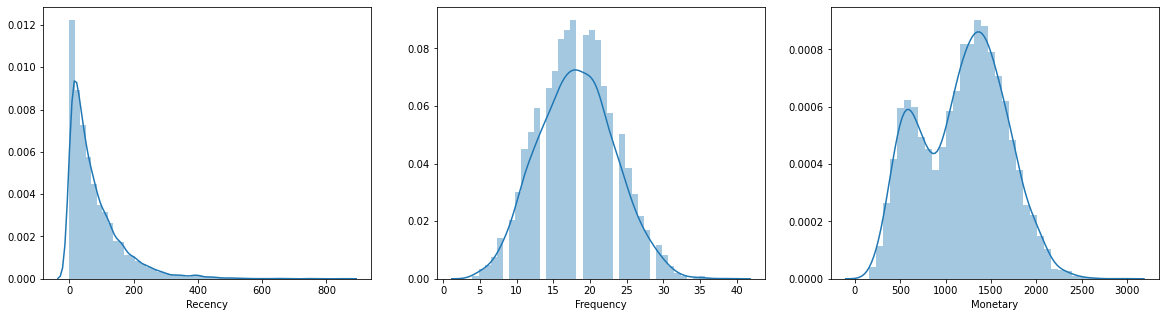

In [10]:
fig, axes = plt.subplots(1,3, figsize=(20,5))
for i, feature in enumerate (list(rfm_df.columns)):
    sns.distplot(rfm_df[feature], ax =axes[i])

Bentuk distribusi Recency skew ke kanan, Frewuency normal, Monetary ada 2 puncak

In [11]:
rfm_df.describe()

,Recency,Frequency,Monetary
count,6889.000000,6889.000000,6889.000000
mean,80.538249,18.144869,1179.269705
std,85.382526,5.193014,465.832609
min,0.000000,4.000000,149.000000
25%,22.000000,14.000000,781.000000
50%,53.000000,18.000000,1227.000000
75%,111.000000,22.000000,1520.000000
max,857.000000,39.000000,2933.000000


Kita bisa lihat meskipun mean Recency 80, median nya 53

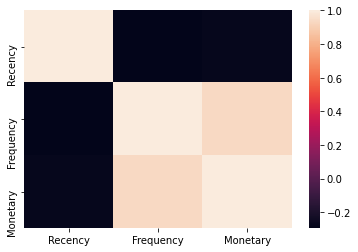

In [12]:
sns.heatmap(rfm_df.iloc[:,0:3].corr())

Frekuensi memiliki korelasi kuat dengan Monetary

## Step 3: Data Standardizing 

Range variabel memiliki variasi yang tinggi. Algoritma K-Means berpatokan pada distance, sehingga range perlu disesuaikan untuk menghindari model yang bias


In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
rfm_std = pd.DataFrame(scaler.fit_transform(rfm_df))
rfm_std.columns = ['s_Recency','s_Frequency','s_Monetary']

In [14]:
rfm_std.describe()

,s_Recency,s_Frequency,s_Monetary
count,6.889000e+03,6.889000e+03,6.889000e+03
mean,3.943556e-17,9.202813e-16,-1.312091e-15
std,1.000073e+00,1.000073e+00,1.000073e+00
min,-9.433323e-01,-2.724024e+00,-2.211834e+00
25%,-6.856496e-01,-7.982203e-01,-8.550252e-01
50%,-3.225513e-01,-2.789885e-02,1.024698e-01
75%,3.567939e-01,7.424226e-01,7.314967e-01
max,9.094579e+00,4.016289e+00,3.764995e+00


## Step 4: Segmenting with K-Means

Menghitung nilai K optimal dengan skor Inersia, Silhouette, dan Calinski_Harabasz.
3 Skor ini dibandingkan dan ditentukan yang terbaik.

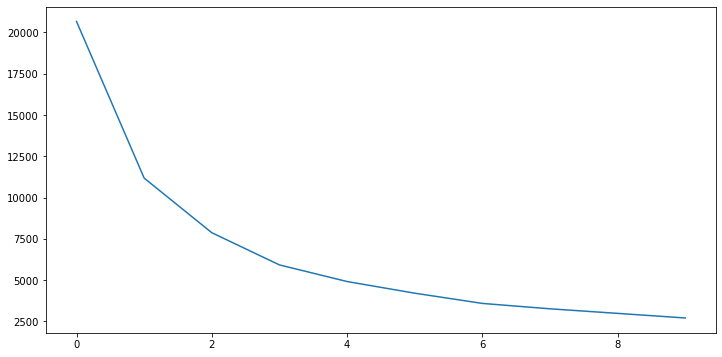

In [15]:
from sklearn.cluster import KMeans
inertia = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(rfm_std.values)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(12, 6))
plt.plot(inertia)

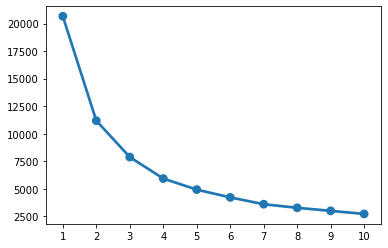

In [16]:
from sklearn.cluster import KMeans
sse=[]

for k in range(0, 10):
    kmeans = KMeans(n_clusters=k+1, max_iter=1000, random_state=42).fit(rfm_std)
    sse.append(kmeans.inertia_)

sns.pointplot(x=list(range(1,11)), y=sse)
plt.show()

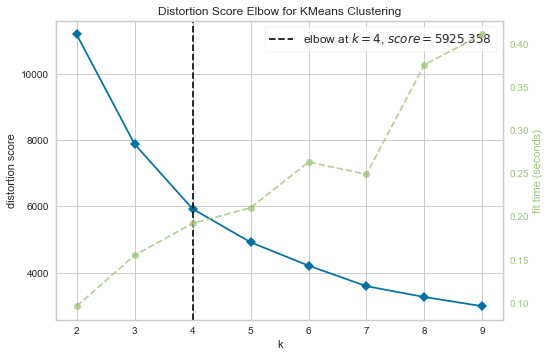

In [17]:
from yellowbrick.cluster import KElbowVisualizer

# k is range of number of clusters.
visualizer = KElbowVisualizer(kmeans, k=(2,10), timings= True)
visualizer.fit(rfm_std)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

Plot inersia terhadap K. Elbow pada K = 4. Setelah K = 4 penurunan inersia tidak signifikan.

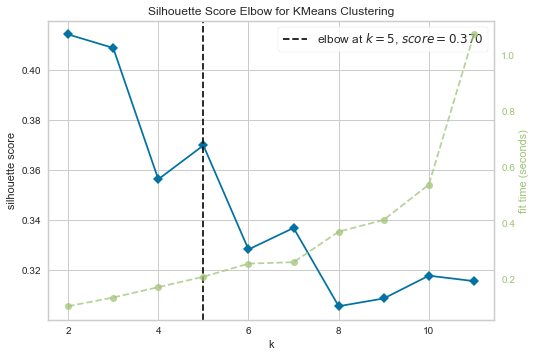

In [18]:

# k is range of number of clusters.
visualizer = KElbowVisualizer(kmeans, k=(2,12),metric='silhouette', timings= True, locate_elbow=True)
visualizer.fit(rfm_std) # Fit the data to the visualizer
visualizer.show() # Finalize and render the figure

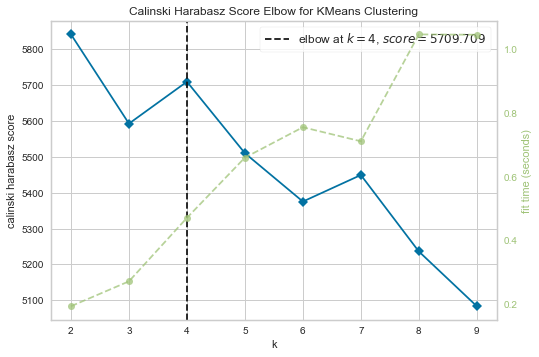

In [19]:
# k is range of number of clusters.
visualizer = KElbowVisualizer(kmeans, k=(2,10),metric='calinski_harabasz', timings= True)
visualizer.fit(rfm_std)        # Fit the data to the visualizer
visualizer.show() # Finalize and render the figure

In [20]:
from yellowbrick.cluster import silhouette_visualizer

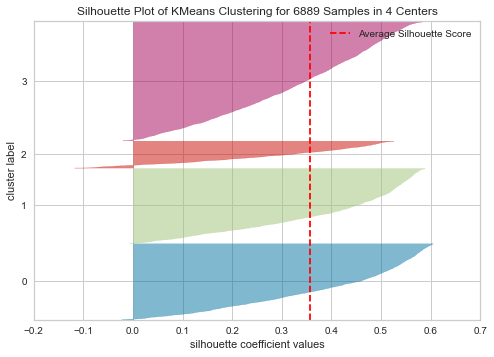

C:\Users\Arif\anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x000002741BDA03A0>,
                     colors='yellowbrick', model=None)

In [21]:
silhouette_visualizer(KMeans(4, random_state=42), rfm_std, colors='yellowbrick')

Untuk K = 4, lebar batang untuk cluster 2 terlihat lebih ramping

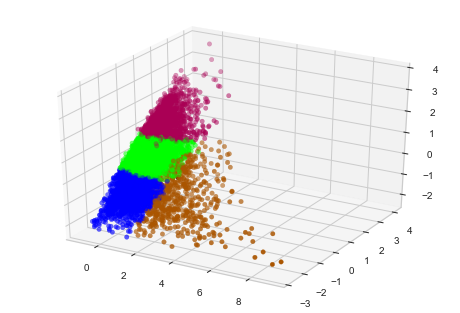

In [22]:
model = KMeans(n_clusters=4,random_state=42).fit(rfm_std)
centers = model.cluster_centers_
fig = plt.figure()
ax = fig.add_subplot(111,projection = '3d')
ax.scatter(rfm_std['s_Recency'],rfm_std['s_Frequency'],rfm_std['s_Monetary'],cmap='brg',c=model.predict(rfm_std))
ax.scatter(centers[:,0],centers[:,1],c='black')

Untuk K = 4, scatter plot terlihat cukup simpel

Kemudian, assign Cluster ke tiap customer_id

In [23]:
rfm_ = pd.DataFrame(scaler.inverse_transform(rfm_std))
rfm_.columns = rfm_df.columns
rfm_['customer_id'] = user['customer_id']
rfm_['Cluster'] = model.labels_

In [24]:
rfm_

,Recency,Frequency,Monetary,customer_id,Cluster
0,111.0,25.0,1637.0,CS5295,1
1,1.0,26.0,1721.0,CS4768,1
2,21.0,23.0,1648.0,CS2122,1
3,77.0,20.0,1431.0,CS1217,3
4,7.0,24.0,1908.0,CS1850,1
...,...,...,...,...,...
6884,142.0,7.0,287.0,CS8478,0
6885,23.0,5.0,209.0,CS8326,0
6886,210.0,8.0,399.0,CS8409,2
6887,38.0,5.0,223.0,CS8479,0


## Step 5: Identify the clusters for further analysis

Menyiapkan data untuk membuat snake plot. Data RFM yang sudah di inverse transform kemudian diubah ke format panjang dengan cara 'melting' kolom-kolom menjadi 2. Satu untuk nama RFM dan satu lagi untuk nilai aktual RFM.

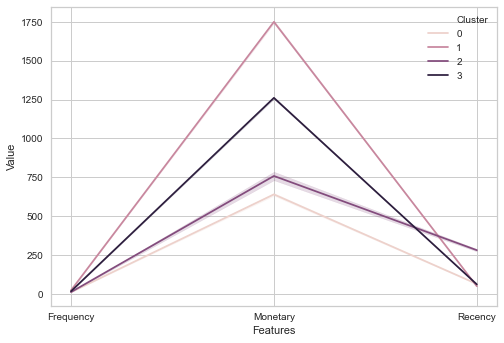

In [25]:
melted_rfm_std = pd.melt(rfm_.reset_index(),
                        id_vars = ['customer_id','Cluster'],
                        value_vars = ['Recency','Frequency','Monetary'],
                        var_name = 'Features',
                        value_name = 'Value')
sns.lineplot('Features','Value',hue='Cluster',data=melted_rfm_std)
plt.show()

In [26]:
melted_rfm_std

,customer_id,Cluster,Features,Value
0,CS5295,1,Recency,111.0
1,CS4768,1,Recency,1.0
2,CS2122,1,Recency,21.0
3,CS1217,3,Recency,77.0
4,CS1850,1,Recency,7.0
...,...,...,...,...
20662,CS8478,0,Monetary,287.0
20663,CS8326,0,Monetary,209.0
20664,CS8409,2,Monetary,399.0
20665,CS8479,0,Monetary,223.0


In [27]:
rfm_.groupby('Cluster').agg({
    'Recency':['mean','min','max'],
    'Frequency':['mean','min','max'],
    'Monetary':['mean','min','max','count']})

Recency                Frequency                 Monetary          \
               mean    min    max       mean   min   max         mean     min   
Cluster                                                                         
0         65.750849    0.0  183.0  12.701586   4.0  19.0   640.852208   149.0   
1         50.922855    0.0  274.0  24.747265  20.0  39.0  1748.647093  1151.0   
2        282.486400  168.0  857.0  13.275200   4.0  23.0   759.080000   157.0   
3         62.913799    0.0  239.0  18.575154  14.0  26.0  1260.564650   684.0   

                       
            max count  
Cluster                
0        1086.0  1766  
1        2933.0  1737  
2        1613.0   625  
3        1658.0  2761

In [46]:
2761/625

4.4176

Sesuai dengan silhouette plot, cluster 2 berukuran terkecil. cluster 3 berukuran 4 kali lebih besar daripada cluster 2

Dari Snake plot dan statistik deskriptif, cluster terbaik adalah cluster 1 dengan nilai mean F tertinggi (pembelian paling sering), nilai mean R terendah (melakukan pembelian belakangan ini / tidak lama dari tanggal observasi, dan nilai mean M tertinggi (volume pembelian tinggi).

Cluster dengan value terendah adalah cluster 0 dengan nilai F dan M terendah.

# RFM Scoring + K-Means

## Step 1: Assigning RFM scores.

Semua variabel di-assign skoring 1 - 5. Standardisasi tidak diperlukan. 5-5-5 untuk best customer, 1-1-1 untuk value terendah.

In [29]:
rfm2 = rfm_df.copy()
rfm2

,Recency,Frequency,Monetary
0,111,25,1637
1,1,26,1721
2,21,23,1648
3,77,20,1431
4,7,24,1908
...,...,...,...
6884,142,7,287
6885,23,5,209
6886,210,8,399
6887,38,5,223


In [30]:
s1 = np.full((1,rfm2.shape[0]-int(0.8002*rfm2.shape[0])),1)
s2 = np.full((1,int(0.20003*rfm2.shape[0])),2)
s3 = np.full((1,int(0.20003*rfm2.shape[0])),3)
s4 = np.full((1,int(0.20003*rfm2.shape[0])),4)
s5 = np.full((1,int(0.20003*rfm2.shape[0])),5)

score = np.hstack((s1,s2,s3,s4,s5)).flatten()

In [31]:
rfm2 = rfm2.sort_values(by='Recency',ascending=False)
rfm2['r_score'] = score

for i,j in zip(('Frequency','Monetary'),('f_score','m_score')):
    rfm2 = rfm2.sort_values(by=i)
    rfm2[j] = score

In [32]:
rfm2

,Recency,Frequency,Monetary,r_score,f_score,m_score
6810,181,4,149,1,1,1
5053,85,5,157,2,1,1
6832,388,4,157,1,1,1
6888,15,5,164,5,1,1
6462,218,5,181,1,1,1
...,...,...,...,...,...,...
2592,151,36,2513,1,5,5
1641,10,33,2527,5,5,5
3850,78,33,2612,2,5,5
109,80,38,2647,2,5,5


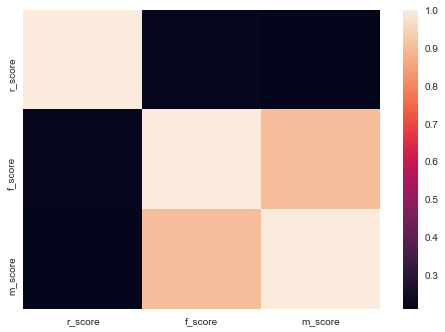

In [33]:
sns.heatmap(rfm2.iloc[:,3:6].corr())

## Step 2: Segmenting with K-Means

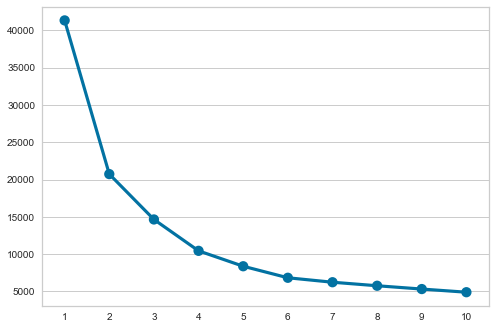

In [34]:
from sklearn.cluster import KMeans
sse=[]

for k in range(0, 10):
    kmeans = KMeans(n_clusters=k+1, max_iter=1000, random_state=42).fit(rfm2.iloc[:,3:])
    sse.append(kmeans.inertia_)

sns.pointplot(x=list(range(1,11)), y=sse)
plt.show()

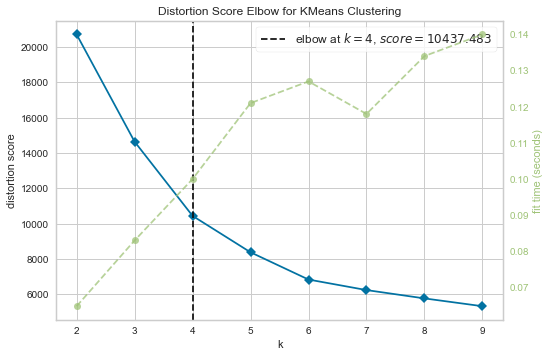

In [35]:
from yellowbrick.cluster import KElbowVisualizer

# k is range of number of clusters.
visualizer = KElbowVisualizer(kmeans, k=(2,10), timings= True)
visualizer.fit(rfm2.iloc[:,3:])        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

Plot inersia terhadap K. Elbow pada K = 4. Setelah K = 4 penurunan inersia tidak signifikan.

C:\Users\Arif\anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\Arif\anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\Arif\anaconda3\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


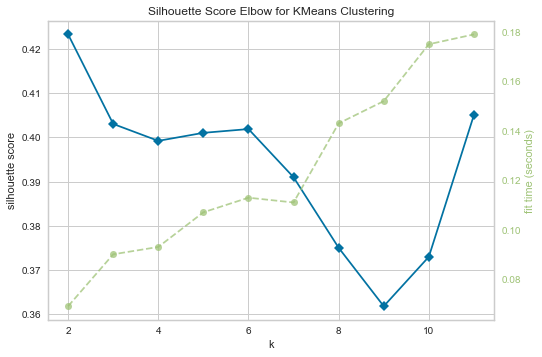

In [36]:
# k is range of number of clusters.
visualizer = KElbowVisualizer(kmeans, k=(2,12),metric='silhouette',timings=True)
visualizer.fit(rfm2.iloc[:,3:])        # Fit the data to the visualizer
visualizer.show()

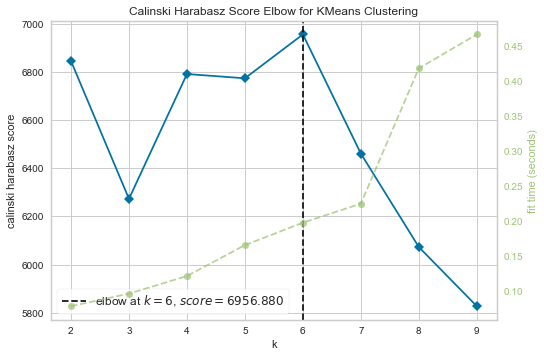

In [37]:
# k is range of number of clusters.
visualizer = KElbowVisualizer(kmeans, k=(2,10),metric='calinski_harabasz',timings= True)
visualizer.fit(rfm2.iloc[:,3:])        # Fit the data to the visualizer
visualizer.show()

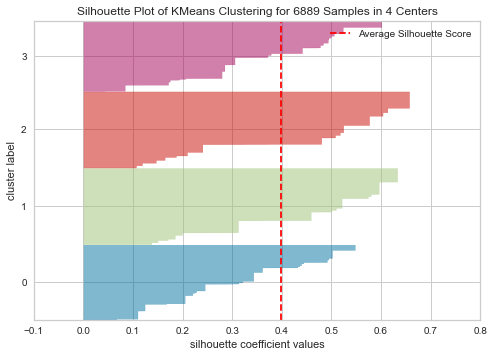

C:\Users\Arif\anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x000002741F248520>,
                     colors='yellowbrick', model=None)

In [39]:
silhouette_visualizer(KMeans(4, random_state=42), rfm2.iloc[:,3:], colors='yellowbrick')

Untuk nilai K = 4, lebar bar terlihat lebih seragam dibandingkan dengan nilai RFM standar.

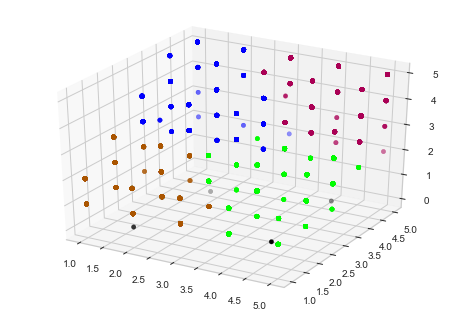

In [40]:
model = KMeans(n_clusters=4,random_state=42, init='k-means++').fit(rfm2.iloc[:,3:])
centers = model.cluster_centers_
fig = plt.figure()
ax = fig.add_subplot(111,projection = '3d')
ax.scatter(rfm2.iloc[:,3],
           rfm2.iloc[:,4],
           rfm2.iloc[:,5],
           cmap='brg',
           c=model.predict(rfm2.iloc[:,3:]))
ax.scatter(centers[:,0],centers[:,1],c='black')

## Step 3: Identify the clusters for further analysis.

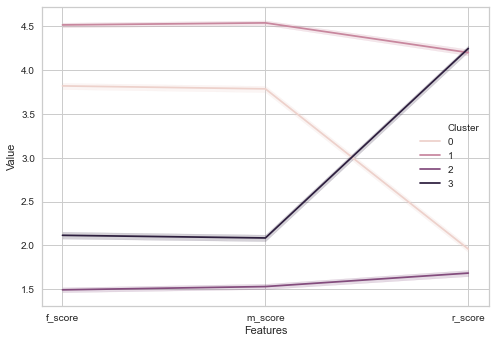

In [41]:
rfm2['Cluster'] = model.labels_

melted_rfm = pd.melt(rfm2.reset_index(),
                        id_vars = ['Cluster'],
                        value_vars = ['r_score','f_score','m_score'],
                        var_name = 'Features',
                        value_name = 'Value')
sns.lineplot('Features','Value',hue='Cluster',data=melted_rfm)
plt.show()

In [42]:
rfm2.groupby('Cluster').agg({
    'Recency':['mean','min','max'],
    'Frequency':['mean','min','max'],
    'Monetary':['mean','min','max','count']})

Recency           Frequency             Monetary                  
               mean min  max       mean min max         mean   min   max count
Cluster                                                                       
0        112.306805  39  424  20.732411  17  38  1436.040369   787  2647  1734
1         24.849153   0   72  23.504520  17  39  1657.193785  1026  2933  1770
2        157.078098  39  857  12.881720   4  19   694.441426   149  1337  1767
3         23.824475   0   72  15.256489   5  22   910.744129   164  1357  1618

In [44]:
1767-1618

149

Perbedaan antara Analisis RFM menggunakan nilai standar dan sistem skoring:

- Ada korelasi kuat antara Frequency dan Monetary.

- Dengan sistem skoring, silhoutte plot menghasilkan lebar kluster yang seragam pada K = 4. Terlihat pada statistik deskriptif, ukuran cluster relatif seragam.


Hasil Segmentasi

- Best Customer : Cluster 1
Frequent and recent shoppers, heavy Spendings

Action: Target customer untuk launching produk baru.

- New Customer : Cluster 3
Recent shoppers, low frequency and spendings.

Action: Perkuat relasi dan pelayanan

- Customer at Risk of Churn : Cluster 0
Frequent and heavy spent shoppers. Sudah lama tidak membeli

Action: Mencari tau alasan pindah. Buat promosi untuk membuat mereka kembali membeli.

- Lost Customer : Cluster 2
Frequency dan spending rendah, juga sudah lama tidak membeli.

Action: Mencari tau alasan pindah. Meningkatkan kualitas produk untuk mencegah loss lebih banyak.

Kesimpulan:

- Analisis RFM bisa mensegmen customer ke kelompok homogen dengan cepat dan sedikit variabel.

- Sistem skoring dapat di-assign definisi skoring yang berbeda.

- Clustering dengan sistem skoring menghasilkan cluster yang lebih seragam.

Tindak lanjut:
Melakukan analisis lebih lanjut untuk cluster 1 (nilai RFM tertinggi) untuk mengekspos lebih banyak insight.